# What do we do here?

We observe that as we run more and more iterations in the Study the NN distance models agains the degrees (in/out degrees). 

In [1]:
import numpy as np
import numba
import sklearn.datasets
import umap
import pynndescent
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.sparse
import sklearn.metrics

from collections import namedtuple

sns.set(rc={"figure.figsize":(12, 12)})

## References for Bayesian updates

* https://www.statlect.com/fundamentals-of-statistics/normal-distribution-Bayesian-estimation
* https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/bayes_Normal_Normal.pdf
* https://www.stat.cmu.edu/~larry/=sml/Bayes.pdf
* https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
* https://web.ics.purdue.edu/~ibilion/www.zabaras.com/Courses/BayesianComputing/GaussianModels-BayesianInference.pdf
* https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution

## Build the Graph

The goal is to contruct a graph with edge weights given by estimating the probability of being the nearest neighbor. How can we estimate such a probability? Surely the sample is either the nearest neighbor or it isn't? We assume sampling has been random and somewhat noisy; but that the distribution of samples is *locally* uniform. In other words we assume that in a local region there is a distribution of distances to the nearest neighbor. This distribution is asymptotically a Gamma distribution; since we are in high dimensions this can be well approximated by a normal distribution (which is much cheaper to model, and to compute probabilities for). Thus for each sample we consider it's local neighborhood and fit a model of the distance to the nearest neighbor for samples in that neighborhood. Given such a model we can then compute the probability that the nearest neighbor of the sample is at least as far away as any given sample, and thus create an edge with w weight given by the probability that this point would have been the nearest neighbor under our model. This provides a (directed!) graph with proabilities assigned to edges.

In [2]:
# Construct the models (using V(X) = E(X^2) - E(X)^2 so we can stream through the data)
# Quirk: We use the 2-out neighborhood and accept the double counting of neighbors of neightbors
#        that overlap. The 2-out lets us see further; the double counting biases toward 
#        the coherent local region as opposed to outliers. Also it just works better. Better
#        options or justifications are more than welcome.
#        nn_dists here is the list of distances to THE nearest neighbor.
@numba.njit(fastmath=True)
def build_models(nn_inds, nn_dists):
    result = np.zeros((nn_inds.shape[0], 2), dtype=np.float32)
    sums = np.zeros(nn_inds.shape[0], dtype=np.float32)
    sums_of_squares = np.zeros(nn_inds.shape[0], dtype=np.float32)
    counts = np.zeros(nn_inds.shape[0], dtype=np.float32)
    # Get sums and counts for the 1-out (not including the points own 1-nn dist)
    for i in range(nn_inds.shape[0]):
        for j in range(1, nn_inds.shape[1]):
            k = nn_inds[i, j]
            if k != i and nn_dists[k] > 0.0: # Skip zero dists since they don't fit the model (!!! Would this work if it was based on dist. of mth closest neighbor, m>1?)
                d = nn_dists[k] # Array of distances
                sums[i] += d
                sums_of_squares[i] += d * d
                counts[i] += 1.0  # Degree of each node - 1 
                
    # Total up totals for the 2-out then compute the mean and std
    for i in range(nn_inds.shape[0]):
        count = 0
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            result[i, 0] += sums[k]
            result[i, 1] += sums_of_squares[k]
            count += counts[k]
            
        result[i, 0] /= count
        result[i, 1] = np.sqrt(result[i, 1] / count - result[i, 0] ** 2)
        
    return result
    
# Create an edge list of the (directed!) prob of being a nearest neighbor
# This amounts to just computing the relevant prob of the relevant normal using erfc from
# the math library.
# Here the nn_dists are the distances to ALL nearest neighbors (not just the first one)
@numba.njit(fastmath=True)
def build_edges(nn_inds, nn_dists, models, max_total_weight=32.0, min_prob=1e-3):
    result = []
    root_two = np.sqrt(2)
    for i in range(nn_inds.shape[0]):
        mean = models[i, 0]
        std = models[i, 1]
        total_weight = 0.0
        
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if nn_dists[i, j] == 0:
                if i != k:
                    result.append((i, k, 1.0))
                else:
                    continue
                    
            d = nn_dists[i, j]
            if std > 0:
                erfc_input = (d - mean) / (root_two * std)
                val = math.erfc(erfc_input) / 2.0
            else:
                val = 0.0
            

            total_weight += val
            if total_weight > max_total_weight or val < min_prob: # Stop if weighted degree of node is large enough or if future neighbors have probs too small.
                break
            else:
                result.append((i, k, val))
            
    return result

# Build the graph: compute nearest neighbors (approximately), build models from them, then make an edge
# list and convert that into a scipy sparse matrix.
def construct_prob_graph(data, n_neighbors=30, metric="euclidean", max_total_weight=32.0, min_prob=1e-3, k=1):
    nn_index = pynndescent.NNDescent(data, metric=metric, n_neighbors=2 * n_neighbors)
    nn_inds, nn_dists = nn_index.neighbor_graph
    models = build_models(nn_inds, nn_dists[:, k])
    
    graph_edges = np.asarray(
        build_edges(nn_inds, nn_dists, models, max_total_weight=max_total_weight, min_prob=min_prob)
    )
    result = scipy.sparse.coo_matrix(
        (graph_edges.T[2], (graph_edges.T[0].astype(np.int32), graph_edges.T[1].astype(np.int32))),
        shape=(data.shape[0], data.shape[0])
    )
    result.eliminate_zeros()
    
    return result

In [13]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

dataset_id = 2
raw_data, targets, dataset_name = get_dataset(dataset_id)
dataset_name

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


'mnist'

In [152]:
data = raw_data
metric="euclidean"
n_neighbors=30
min_cluster_size=800
max_total_weight=64.0 
min_prob=1e-3
prior=10.0
noise_prior_prob=0.01 
max_iter=100 
tolerance=1e-5
k=1

In [153]:
prob_graph = construct_prob_graph(
    data, 
    n_neighbors=n_neighbors, 
    metric=metric, 
    max_total_weight=max_total_weight, 
    min_prob=min_prob,
    k=k,
)
adj_matrix = (prob_graph>0)
models = build_models(nn_inds, nn_dists):

In [154]:
in_degrees = adj_matrix.sum(axis=0).tolist()[0]
out_degrees = adj_matrix.sum(axis=1).T.tolist()[0]
nn_index = pynndescent.NNDescent(data, metric=metric, n_neighbors=2 * n_neighbors)
nn_inds, nn_dists = nn_index.neighbor_graph
dist_to_nn = nn_dists[:, 1]

In [167]:
result = np.zeros((nn_inds.shape[0], 2), dtype=np.float32)
sums = np.zeros(nn_inds.shape[0], dtype=np.float32)
sums_of_squares = np.zeros(nn_inds.shape[0], dtype=np.float32)
counts = np.zeros(nn_inds.shape[0], dtype=np.float32)
# Get sums and counts for the 1-out (not including the points own 1-nn dist)
for i in range(nn_inds.shape[0]):
    for j in range(1, nn_inds.shape[1]):
        k = nn_inds[i, j]
        if k != i and dist_to_nn[k] > 0.0: # Skip zero dists since they don't fit the model (!!! Would this work if it was based on dist. of mth closest neighbor, m>1?)
            d = dist_to_nn[k] # Array of distances
            sums[i] += d
            sums_of_squares[i] += d * d
            counts[i] += 1.0

# Total up totals for the 2-out then compute the mean and std
for i in range(nn_inds.shape[0]):
    count = 0
    for j in range(nn_inds.shape[1]):
        k = nn_inds[i, j]
        result[i, 0] += sums[k]
        result[i, 1] += sums_of_squares[k]
        count += counts[k]

    result[i, 0] /= count
    result[i, 1] = np.sqrt(result[i, 1] / count - result[i, 0] ** 2)

In [174]:
df = pd.DataFrame({"dist_to_nn": dist_to_nn, "in_degrees":in_degrees, "out_degrees":out_degrees})
df['1out_mean'] = sums/counts
df['2out_mean'] = result[:,0]

[Text(0.5, 1.0, 'Distribution 2-out mean NN distances')]

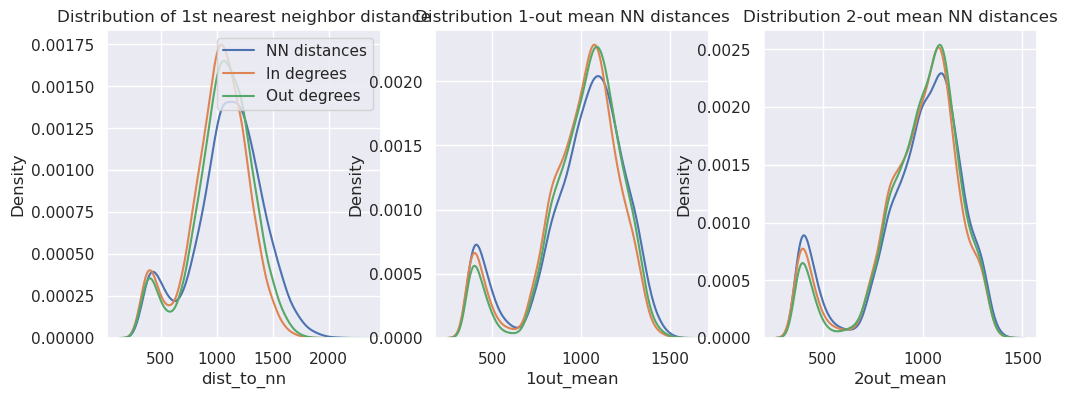

In [181]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.kdeplot(df, x="dist_to_nn", ax=ax[0])
sns.kdeplot(df, x="dist_to_nn", weights="in_degrees", ax=ax[0])
sns.kdeplot(df, x="dist_to_nn", weights="out_degrees", ax=ax[0])
ax[0].set(title='Distribution of 1st nearest neighbor distance')
ax[0].legend(labels=['NN distances', 'In degrees', 'Out degrees', 'High out degrees', 'Low out degrees'], loc="upper right")

sns.kdeplot(df, x="1out_mean", ax=ax[1])
sns.kdeplot(df, x="1out_mean", weights="in_degrees", ax=ax[1])
sns.kdeplot(df, x="1out_mean", weights="out_degrees", ax=ax[1])
ax[1].set(title='Distribution 1-out mean NN distances')

sns.kdeplot(df, x="2out_mean", ax=ax[2])
sns.kdeplot(df, x="2out_mean", weights="in_degrees", ax=ax[2])
sns.kdeplot(df, x="2out_mean", weights="out_degrees", ax=ax[2])
ax[2].set(title='Distribution 2-out mean NN distances')

In [188]:
print(f'{np.average(dist_to_nn):.2f} : average of NN distances')
print(f'{np.average(dist_to_nn, weights=in_degrees):.2f} : average of NN distances weighted by in-degrees')
print(f'{np.average(dist_to_nn, weights=out_degrees):.2f} : average of NN distances weighted by out-degrees')

1096.06 : average of NN distances
1010.02 : average of NN distances weighted by in-degrees
1050.68 : average of NN distances weighted by out-degrees


In [189]:
print(f'{np.average(df["1out_mean"]):.2f} : average of means of 1-out distances')
print(f'{np.average(df["1out_mean"], weights=in_degrees):.2f} : average of means of 1-out distances weighted by in-degrees')
print(f'{np.average(df["1out_mean"], weights=out_degrees):.2f} : average of means of 1-out distances weighted by out-degrees')

999.81 : average of means of 1-out distances
982.35 : average of means of 1-out distances weighted by in-degrees
1009.67 : average of means of 1-out distances weighted by out-degrees


In [190]:
print(f'{np.average(df["2out_mean"]):.2f} : average of NN distances')
print(f'{np.average(df["2out_mean"], weights=in_degrees):.2f} : average of means of 2-out distances weighted by in-degrees')
print(f'{np.average(df["2out_mean"], weights=out_degrees):.2f} : average of means of 2-out distances weighted by out-degrees')

963.05 : average of NN distances
960.47 : average of means of 2-out distances weighted by in-degrees
978.92 : average of means of 2-out distances weighted by out-degrees


[Text(0.5, 1.0, 'Out degree distribution')]

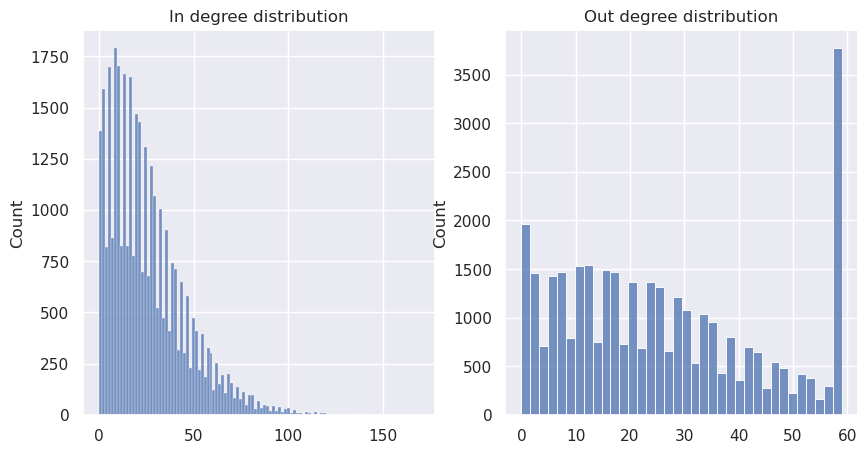

In [60]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(in_degrees, ax=ax[0]).set(title='In degree distribution')
sns.histplot(out_degrees, ax=ax[1]).set(title='Out degree distribution')

[Text(0.5, 1.0, 'Distance to nearest neighbor per in degree (rounded)')]

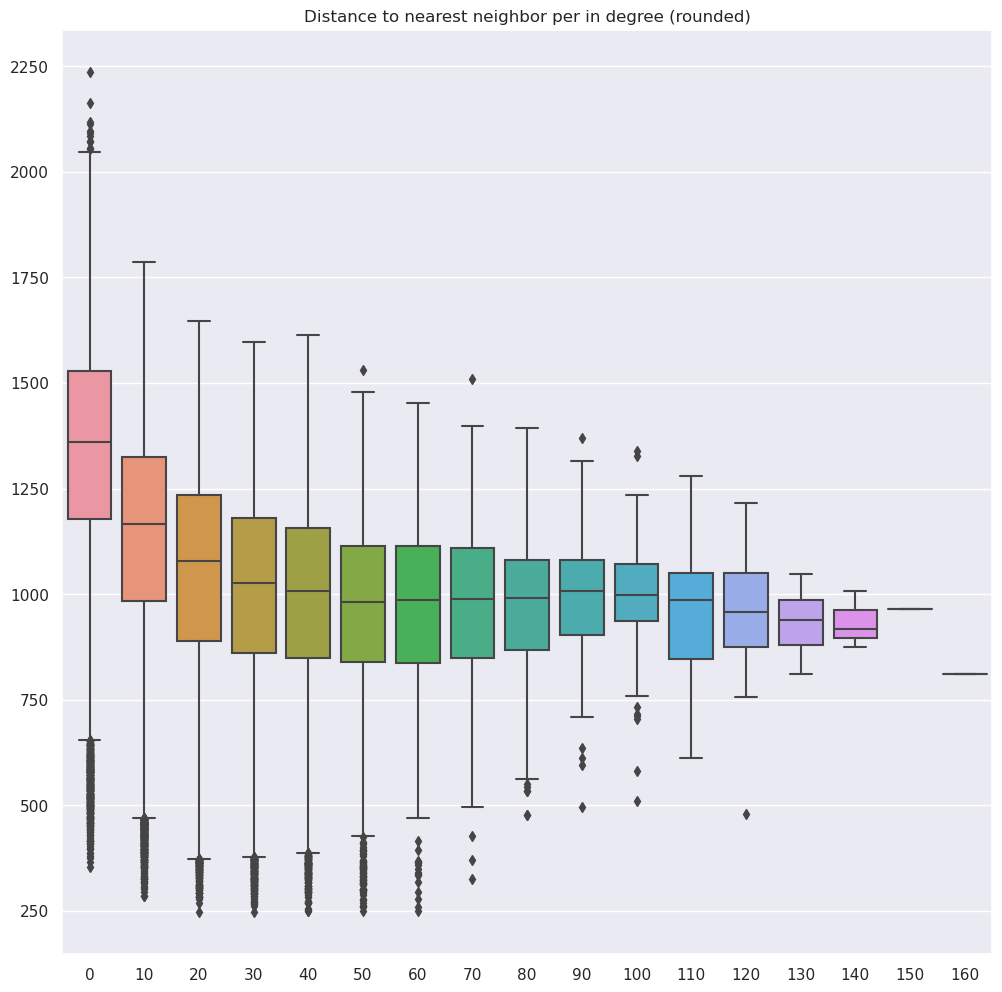

In [149]:
sns.boxplot(x=[10*(x//10) for x in in_degrees], y=dist_to_nn).set(title='Distance to nearest neighbor per in degree (rounded)')

[Text(0.5, 1.0, 'Distance to nearest neighbor per out degree (rounded)')]

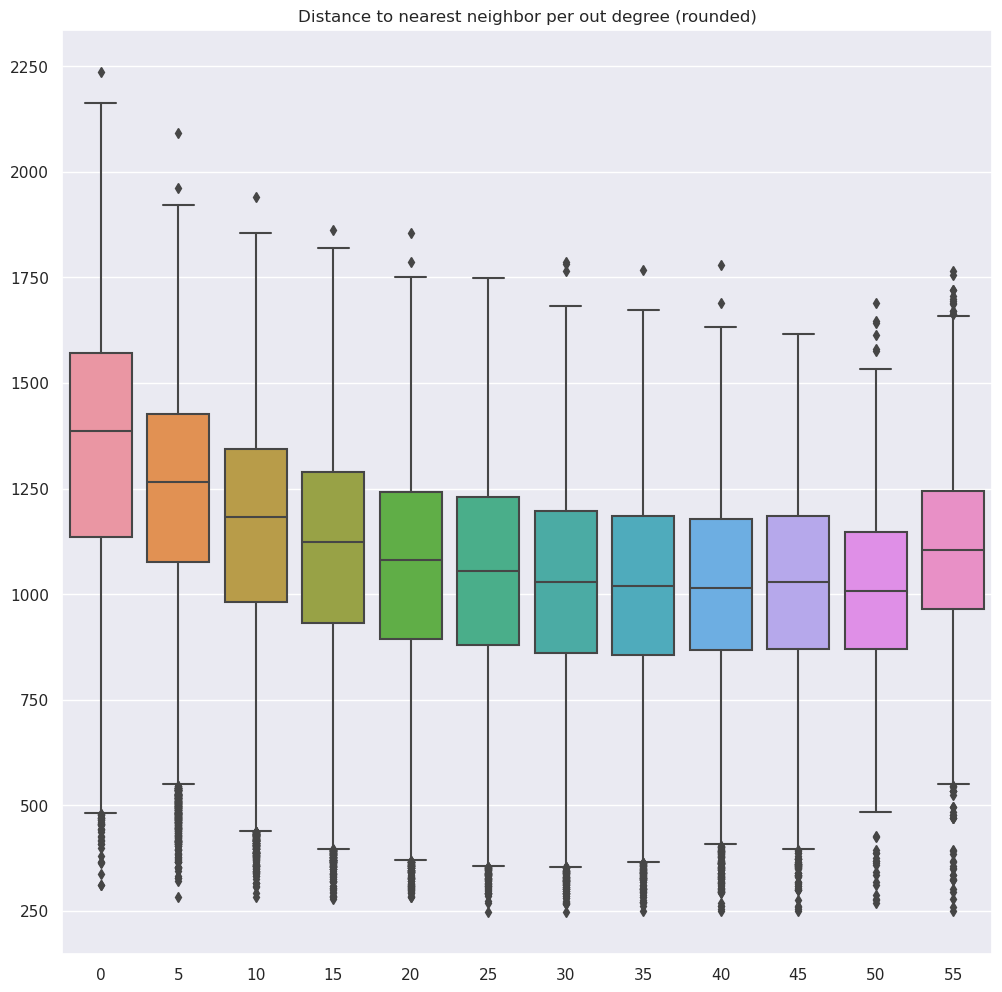

In [150]:
sns.boxplot(x=[5*(x//5) for x in out_degrees], y=dist_to_nn).set(title='Distance to nearest neighbor per out degree (rounded)')

In [191]:
dist_to_nn = nn_dists[:, 1]
prior = np.array([np.average(dist_to_nn[dist_to_nn>0]), np.std(dist_to_nn[dist_to_nn>0])])
prior

array([1096.0575 ,  317.23474], dtype=float32)

# Discussion with Leland

For a noisy 2-d dataset (that I called clusterable in previous notebooks) the algorithm above does not perform well. This is true even if we replace the normal distributions by the - proper for low dimensional - Gamma distributions. However, if instead of computing local nearest neighbor distributions we use a global one for this example, it works better. Moreover, if we use a log-normal distribution, instead of the proper Gamma, it again works better. However, the log-normal does not work as well on the high dimensional examples.
* Could a (global) prior distribution be used and updated locally? How?
* What makes the global distribution more adapted for the clusterable example: low dimensionality or high noise level in the data?
* What about log-normal distributions? Why is it that they better fit the observed distributions?

### Problem with min-cluster-size.

The min-cluster-size parameter is used to build the condensed tree that is in turn use to seed the label propagation step of the algorithm. Because of the label propagation step, the minimum cluster size given in the parameters can be much smaller than the minimum cluster size. With the Japanese character Kuzushiji-MNIST Dataset, we observe the following problem. If the min-cluster-size is not small enough, some of the smallish clusters are just labelled as noise. If we make the min-cluster-size small enough, we fix the problem but we introduce a new one: larger clusters get split into smaller ones. It's almost as if we would want to find persisting "propagated groups" over min-cluster-size values.

I have a question here: can each point have a notion of at which min-cluster-size value it would have... no, does not work.

### The models

When constructing the local models for the distributions of the distances to the nearest neighbor, we first used Gaussian estimations based on average of k-NN distances of a point and of its neighbors' k-NN distances. This is explicitely deciding that the notion of "local" is limited to the 2-out subgraphs, that is limited to distances between neighbors and neighbors of neighbors. (the proper distribution to model NN distances is a gamma distribution (?) but 
In order to avoid a hard boundary like this, we can start by fixing a prior identical at all points, based on the global distribution of NN distances. and update the prior given 